In [100]:
import numpy as np
from numpy import savetxt
from numpy import genfromtxt
import sys
import random
import matplotlib.pyplot as plt 
from numba import jit
from scipy.optimize import curve_fit

**Parameters' definition**

In [101]:
par_sigma = 0.1 ##[sigma]= [min]$^{-1}$
par_lambda = 0.139 #[lambda]= [min]$^{-1}$
#Parameter's simulation:
dt = 0.01 #[dt]=[min]
N= 5000000

#Probability of staying in polarized state:
P = par_lambda/(par_lambda+par_sigma) #P= 0.58

#Diffusivity parameters:
D_iso = 1. #[D]=[macro m^2]/[min]
D_phi = 0.1 #[D_phi]=[min]^{-1}
Dp = 1 #[D]=[macro m^2]/[min]
D_delta = 0.04 #[D_delta] = [min]^-1

# Setting various noise parameter for stocastic motion:
k_phi = np.sqrt(2*D_phi)
k = np.sqrt(2*D_iso)
k_pol = np.sqrt(2*Dp)
k_delta = np.sqrt(2*D_delta)

#Parameters describing the elastic interaction within the cell-cargo couple
alpha = 2 #[alpha] = [min]^-1

#Cells' mean velocity:
v0=6 #[v0]=[macro m]/[min]

#Equilibrium distance of cell-cargo system 
l0= 18 #relative distance [l0]=[macrom]


**Setting my clock**

In [102]:
N_list = [0]
state_list = []

t = -1/par_lambda * np.log(np.random.rand())
t = int(t/dt)                                    
N_list.append(t + N_list[-1])
state_list.append('I')

t1 = -1/(par_lambda+par_sigma) * np.log(np.random.rand())
t1 = int(t1/dt)                                    
N_list.append(t1 + N_list[-1])
state_list.append('P')

TotalIso = t;
TotalPol = t1;

nIsoEpisodes = 1;
nPolEpisodes = 1;

while N_list[-1] < N:
    
    if state_list[-1] == 'I':

        # you must go to state P
        t1 = -1/(par_lambda+par_sigma) * np.log(np.random.rand())
        t1 = int(t1/dt)  

        while t1 == 0:
            t1 = -1/(par_lambda+par_sigma) * np.log(np.random.rand())
            t1 = int(t1/dt)  

        N_list.append(t1 + N_list[-1])
        state_list.append('P')

        TotalPol = TotalPol + t1
        nPolEpisodes = nPolEpisodes + 1

    # state_list[-1] == 'P'
    else: 

        if P > np.random.rand():
            t1 = -1/(par_lambda+par_sigma) * np.log(np.random.rand())
            t1 = int(t1/dt)  

            while t1 == 0:
                t1 = -1/(par_lambda+par_sigma) * np.log(np.random.rand())
                t1 = int(t1/dt)  

            N_list.append(t1 + N_list[-1])
            state_list.append('P')

            TotalPol = TotalPol + t1
            nPolEpisodes = nPolEpisodes + 1

        else:
            t = -1/par_lambda * np.log(np.random.rand())
            t = int(t/dt)                                    

            while t == 0:
                t = -1/par_lambda * np.log(np.random.rand())
                t = int(t/dt)                                    

            N_list.append(t + N_list[-1])
            state_list.append('I')

            TotalIso = TotalIso + t
            nIsoEpisodes = nIsoEpisodes + 1
        
N_list[-1] = N
states = list(zip(zip(N_list[:-1],N_list[1:]),state_list))

**Defining simulation vectors**

In [103]:
phi = np.zeros(N+1)
x = np.zeros(N+1)
y = np.zeros(N+1)
ux = np.zeros(N+1)
uy = np.zeros(N+1)
time = np.arange(0,(N+1)*dt, dt)
theta = np.zeros(N+1)
# ex = np.zeros(N+1)
# ey = np.zeros(N+1)
X = np.zeros(N+1)
Y = np.zeros(N+1)
relx = np.zeros(N+1)
rely = np.zeros(N+1)
relabs= np.zeros(N+1)
#------------------#
#setting initial condition:
# phi[0] = 0.
x[0] = 0.
y[0] = 0.
ux[0]= 1.
uy[0]= 0.


**Functions:**

Note: Numba compiles numerical algorithms in Python with a speed that can approach C or FORTRAN.
Further documentation [here]( https://numba.readthedocs.io/en/stable/user/5minguide.html).



In [120]:
@jit(nopython=True, fastmath=True)
def Brownian_motion(Nin, Nfin, dt, w, m):
    for j in range(Nin, Nfin):
        w[j+1]=w[j]+m*np.sqrt(dt)*np.random.randn()
    return w

#Brownian_motion(0, 1, dt, x, 2)

In [121]:
@jit(nopython=True, fastmath=True)
def Polarized_motion(Nin, Nfin, dt, x, y, m, v0, phi): #change phi into theta +eta
    for j in range(Nin, Nfin):
        x[j+1]=x[j] + v0*np.cos(phi[j])*dt+m*np.sqrt(dt)*np.random.randn()
        y[j+1]=y[j] + v0*np.sin(phi[j])*dt+m*np.sqrt(dt)*np.random.randn()
    return x, y

In [122]:
@jit(nopython=True, fastmath=True)
def ForwardEuler_iso(nin, nfin, dt, ux, uy, alpha, m):
    for k in range(nin, nfin):
        tmp_theta = np.arctan2(uy[k],ux[k]);

        ux[k+1] = ux[k] + dt*(-alpha)*(ux[k] - np.cos(tmp_theta))+m*np.sqrt(dt)*np.random.randn()
        uy[k+1] = uy[k] + dt*(-alpha)*(uy[k] - np.sin(tmp_theta))+m*np.sqrt(dt)*np.random.randn()

    return ux, uy

In [123]:
@jit(nopython=True, fastmath=True)
def ForwardEuler_pol(nin, nfin, dt, ux, uy, m, p, alpha):
    # print(p[nin])
    for k in range(nin, nfin):
        ux[k+1]=ux[k]+dt*(-alpha)*(ux[k]+np.cos(p[k]))+m*np.sqrt(dt)*np.random.randn()
        uy[k+1]=uy[k]+dt*(-alpha)*(uy[k]+np.sin(p[k]))+m*np.sqrt(dt)*np.random.randn()
    return ux, uy

In [124]:
@jit(nopython=True, fastmath=True)
def theta_compute(Nin, Nfin, ux, uy, theta): #compute directly theta from arctan2 uy/ux without ex and ey
    for j in range(Nin, Nfin+1):      
        theta[j] = np.arctan2(uy[j], ux[j])
    return theta

In [125]:
@jit(nopython=True, fastmath=True)
def VACF_fit(x, v, a, b, c):
    return (v * np.exp(-a * x)*np.cos(b*x+c))

In [126]:
@jit(nopython=True, fastmath=True)
def Mem_kernel(Cvv, dt):
  ##Function which return g = Memory Kernel, G = integration of memory kernel
  nsamples = len(Cvv)-1

  G = np.zeros(nsamples)
  g = np.zeros(nsamples)
    
  G[0] = 2.*(Cvv[0]-Cvv[1])/(Cvv[0]+Cvv[1])
  for ii in range(1,nsamples):
    G[ii] = 2.*(Cvv[0]-Cvv[ii+1])/(Cvv[0] + Cvv[1])
    s = 0
    for jj in range(0,ii): 
      s = s + G[ii-(jj+1)]*(Cvv[jj+2] + Cvv[jj+1])/(Cvv[0] + Cvv[1])
    G[ii] = G[ii] - s

  # normalize
  G = G/dt
    
  # differentiate
  g[0] = 2*G[0]/dt
  g[1:] = np.diff(G)/dt;

  return G, g

**Motility of the cell + director**

In [127]:
for (Nin, Nfin), state in states:
    if state == 'I':
        x = Brownian_motion(Nin, Nfin, dt, x, k)
        y = Brownian_motion(Nin, Nfin, dt, y, k)
        ux, uy= ForwardEuler_iso(Nin, Nfin, dt, ux, uy, alpha, k_delta)
    if state == 'P':
        phi[Nin] = theta[Nin]+np.random.normal(0,0.2)
        phi = Brownian_motion(Nin, Nfin, dt, phi, k_phi)
        x ,y = Polarized_motion(Nin, Nfin, dt, x,y, k_pol, v0, phi)
        ux, uy = ForwardEuler_pol(Nin, Nfin, dt, ux, uy, k_delta, phi, alpha)
    
    theta = theta_compute(Nin, Nfin, ux, uy, theta)

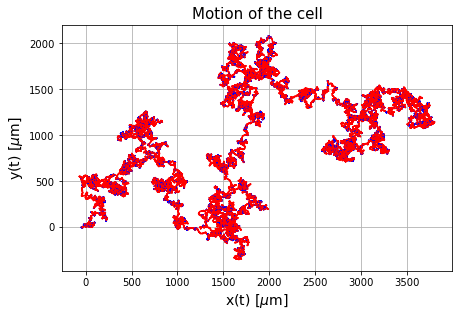

In [128]:
fig,ax = plt.subplots(figsize=(7, 8))
ax.set_ylabel('y(t) [$\mu$m]', fontsize=14)
ax.set_xlabel('x(t) [$\mu$m]', fontsize=14)
ax.set_title('Motion of the cell', fontsize=15)
ax.set_aspect('equal')
ax.grid()

for (Nin, Nfin), state in states:
    
    if state == 'I':        
        ax.plot(x[Nin:Nfin],y[Nin:Nfin],'b')
    else: 
        ax.plot(x[Nin:Nfin],y[Nin:Nfin],'r')

#plt.savefig('cell_motion.png')           
plt.show()

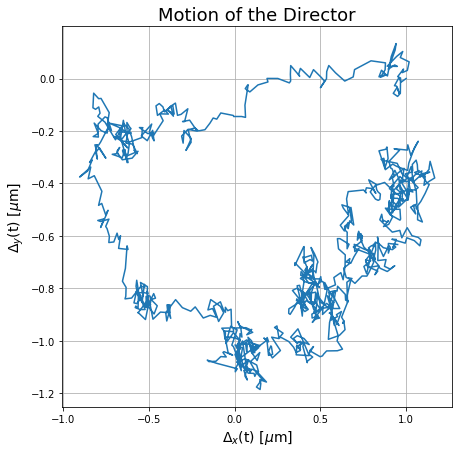

In [129]:
fig,ax = plt.subplots(figsize=(7, 7))
ax.set_ylabel('$\Delta_y$(t) [$\mu$m]', fontsize=14)
ax.set_xlabel('$\Delta_x$(t) [$\mu$m]', fontsize=14)
ax.set_title('Motion of the Director', fontsize=18)
ax.grid()

ax.plot(ux[0:1000] ,uy[0:1000])
plt.show()

**Motion of the cargo particle**

In [130]:
X=x+l0*ux
Y=y+l0*uy
relx = X-x
rely = Y-y
relabs = np.sqrt(relx**2+rely**2)

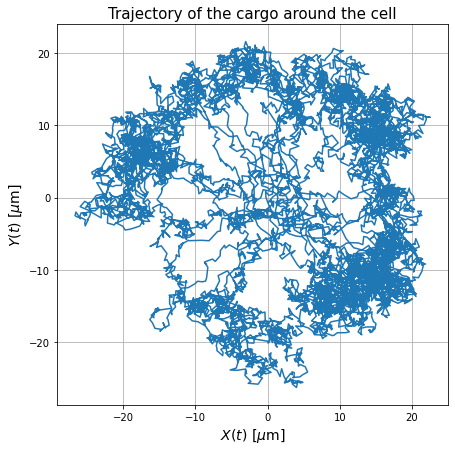

In [131]:
fig,ax = plt.subplots(figsize=(7, 7)) #for presentation plotted only first 10.000 steps
ax.set_ylabel('$Y(t)$ [$\mu$m]', fontsize=14)
ax.set_xlabel('$X(t)$ [$\mu$m]', fontsize=14)
ax.set_title('Trajectory of the cargo around the cell', fontsize=15)
ax.grid()
ax.plot(relx[0:10000],rely[0:10000])
plt.savefig('cargo_motion.png')  

plt.show()

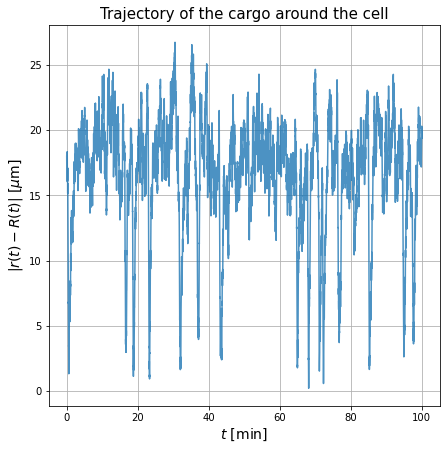

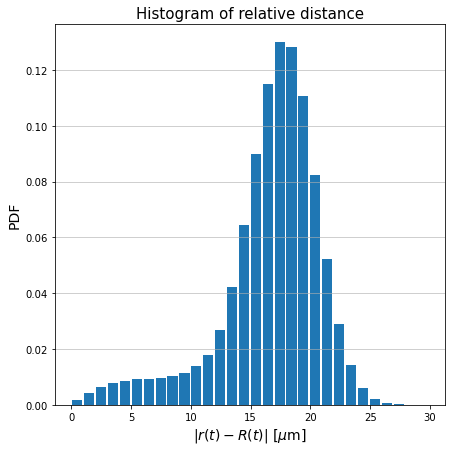

In [132]:
fig,ax = plt.subplots(figsize=(7, 7))
ax.set_ylabel('$ |r(t) - R(t)| $ [$\mu$m]', fontsize=14)
ax.set_xlabel('$t$ [min]', fontsize=14)
ax.set_title('Trajectory of the cargo around the cell', fontsize=15)
ax.grid()
ax.plot(time[0:10000], relabs[0:10000], alpha = 0.8)
#plt.savefig('cargo_motion_time.png') 



fig,ax = plt.subplots(figsize=(7, 7))
ax.set_ylabel('PDF', fontsize=14)
ax.set_xlabel('$ |r(t) - R(t)| $ [$\mu$m]', fontsize=14)
ax.set_title('Histogram of relative distance', fontsize=15)
ax.grid(axis='y', alpha=0.75)
ax.hist(relabs, bins=30,density = True, rwidth=0.85)

plt.show()


**Computation of $C_{vv}(t)$ for the cargo particle**

In [133]:
vx = np.zeros(N)
vy = np.zeros(N)
#v = np.zeros(N)
for k in range(N):
    vx[k]=(X[k+1]-X[k])/dt
    vy[k]=(Y[k+1]-Y[k])/dt
   
vx = vx[10000:N]
vy = vy[10000:N]


vXacf = np.fft.ifft(np.abs(np.fft.fft(vx))**2)/len(vx)
vYacf = np.fft.ifft(np.abs(np.fft.fft(vy))**2)/len(vy)

vXacf = np.real(vXacf[0:len(vXacf)//60])
vYacf = np.real(vYacf[0:len(vYacf)//60])

vacf = vXacf + vYacf


l =np.arange(len(vacf))*dt

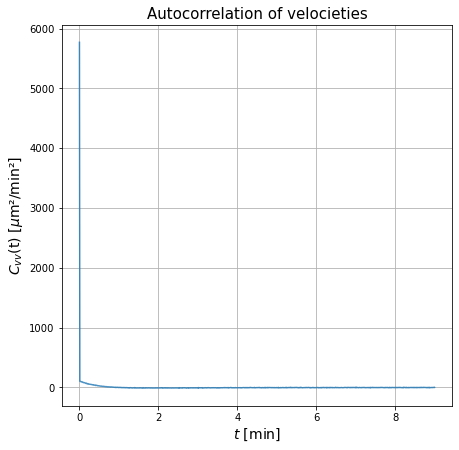

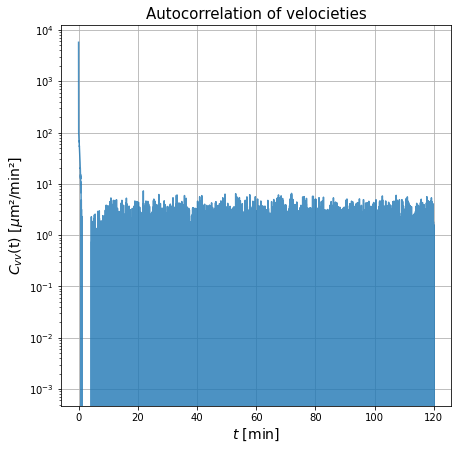

In [134]:
fig,ax = plt.subplots(figsize=(7, 7))
ax.set_ylabel('$C_{vv}$(t) [$\mu$m²/min²]', fontsize=14)
ax.set_xlabel('$t$ [min]', fontsize=14)
ax.set_title('Autocorrelation of velocieties', fontsize=15)
ax.grid()
ax.plot(l[0:900], vacf[0:900], alpha = 0.8)
plt.savefig('cvv_linear.png')
plt.show()

fig,ax1 = plt.subplots(figsize=(7, 7))
ax1.set_ylabel('$C_{vv}$(t) [$\mu$m²/min²]', fontsize=14)
ax1.set_xlabel('$t$ [min]', fontsize=14)
ax1.set_title('Autocorrelation of velocieties', fontsize=15)
ax1.grid()
#ax1.semilogy(l[], vacf, alpha = 0.8)
ax1.semilogy(l[0:12000], vacf[0:12000], alpha = 0.8)
plt.savefig('cvv_log1.png')
plt.show()

**Smoothing the delta peak**

In [138]:
#print(vacf[0:100])
p = np.polyfit(l[1:100], vacf[1:100], 5)
print(p)
cFuncAct = np.polyval(p,0)
print(cFuncAct)
cDeltaInf = vacf[0] - cFuncAct;
print(cDeltaInf)
vacf[0]  = cFuncAct
#print(vacf[0:100])

[-172.73892458  479.06823435 -550.21322534  419.24843345 -283.66825327
  108.3021185 ]
108.30211850207793
0.0


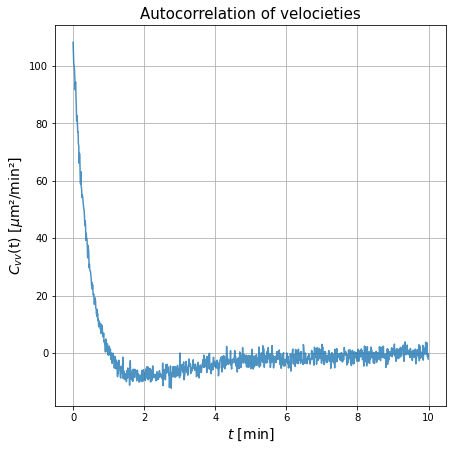

In [139]:
fig,ax = plt.subplots(figsize=(7, 7))
ax.set_ylabel('$C_{vv}$(t) [$\mu$m²/min²]', fontsize=14)
ax.set_xlabel('$t$ [min]', fontsize=14)
ax.set_title('Autocorrelation of velocieties', fontsize=15)
ax.grid()
#ax.set_xlim(-0.2, 0.05)
ax.plot(l[0:1000], vacf[0:1000], alpha = 0.8)
plt.savefig('cvv_linear.png')
plt.show()


**Fitting procedure**

Goal: obtain clean, noise free autocorrelation of velocities.
From [[1]](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.101.032408) we know:
\begin{equation}
C_{vv}(t) = A \cdot e^{-\frac{t}{t_p}}+B \cdot e^{-\frac{t}{t_b}} = A \cdot e^{- k_p \cdot t}+B \cdot e^{-k_b \cdot t},
\end{equation}
where:

$A = (a+ib)$,

$B = A^*= (a-ib)$,

$k_p = (c+id)$,

$k_b = k_b^{*}=(c-id)$,

and $C_{vv}(t)$ can be rewritten as:

\begin{equation}
C_{vv}(t) = (a+ib) \cdot e^{(c+id)t}+(a-ib) \cdot e^{(c-id)t} = ... = 
\end{equation}

\begin{equation}
= 2 \cdot e^{c \cdot t}{a \cdot \cos(d \cdot t) +b \cdot \sin(d \cdot t)}.
\end{equation}

Substituing:

\begin{equation}
\begin{cases} 
a = \frac{E}{2} \cos(\phi), \\
b = \frac{E}{2} \sin(\phi);
\end{cases}
\end{equation}

then $C_{vv}(t)$ becomes:

\begin{equation}
C_{vv}(t) = E \cdot e^{c \cdot t} \cdot \cos(d \cdot t +\phi).
\end{equation}


From [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html):

popt =: Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized.

pcov := the estimated covariance of popt

In [68]:
fit_cvv = vacf[0:1000]
fit_t = l[0:1000]

In [71]:
popt, pcov = curve_fit(VACF_fit, fit_t, fit_cvv, maxfev=10000) 
print(popt, pcov)

[ 2.39066315e+04  1.16263287e+00 -4.15096901e-03 -1.41329015e+01] [[ 6.58981160e+13  2.87731159e+04  1.14332174e+07 -1.17485019e+07]
 [ 2.87731159e+04  8.22568470e-05  4.99189203e-03 -5.12964772e-03]
 [ 1.14332174e+07  4.99189203e-03  1.98364489e+00 -2.03834624e+00]
 [-1.17485019e+07 -5.12964772e-03 -2.03834624e+00  2.09455604e+00]]


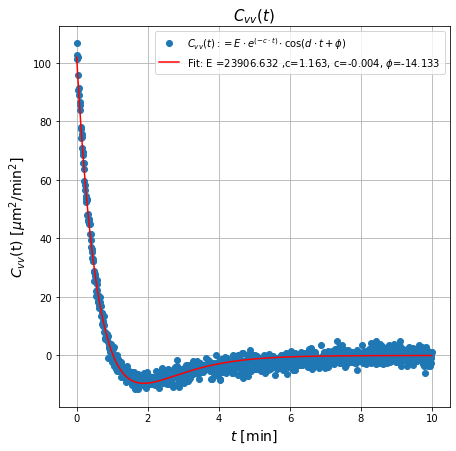

In [74]:
fig,ax = plt.subplots(figsize=(7, 7))
ax.set_ylabel('$C_{vv}$(t) [$\mu$m$^2$/min$^2$]', fontsize=14)
ax.set_xlabel('$t$ [min]', fontsize=14)
ax.set_title('$C_{vv}(t)$', fontsize=15)
ax.grid()
ax.plot(fit_t, fit_cvv, 'o', label="$C_{vv}(t):= E \cdot e^{(-c \cdot t)} \cdot \cos(d \cdot t+\phi) $")
ax.plot(fit_t, VACF_fit(fit_t, *popt), 'r-', label='Fit: E =%5.3f ,c=%5.3f, c=%5.3f, $\phi$=%5.3f' % tuple(popt))
plt.legend()
#plt.savefig('cvv_fit.png')
plt.show()

In [94]:
v, a, b, c= popt
tt = np.arange(5000)*dt
sin_cvv = VACF_fit(tt, v, a, b, c)

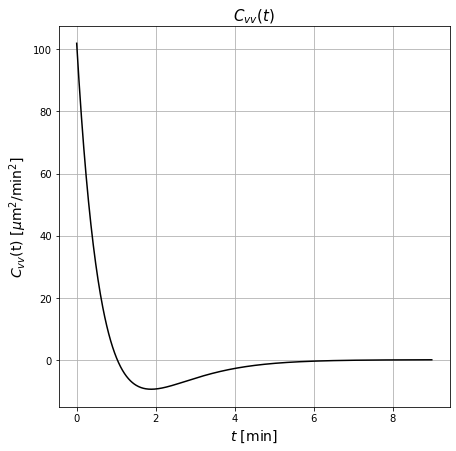

In [95]:
fig,ax = plt.subplots(figsize=(7, 7))
ax.set_ylabel('$C_{vv}$(t) [$\mu$m$^2$/min$^2$]', fontsize=14)
ax.set_xlabel('$t$ [min]', fontsize=14)
ax.set_title('$C_{vv}(t)$', fontsize=15)
ax.grid()
ax.plot(tt[0:900], sin_cvv[0:900], 'k-')
#plt.savefig('cvv_sin.png')
plt.show()

**Towards a Non Markovian Model**

$C_{vv}(t)$trend claims a more general model, which is represented by the Generalized Langevin Equation (GLE):
\begin{equation}
\dot{v}(t) = -U(x(t))\int_{-\inf}^t ds \Gamma_v(t-s)v(s)+F_R(t),
\end{equation}
where it has been assumed: $U(x(t)) = 0$.
The introduction of the memory term accounts for non-Markovian effects, describing for how long the system will remember its past states.



In [96]:
G, K = Mem_kernel(sin_cvv, dt)

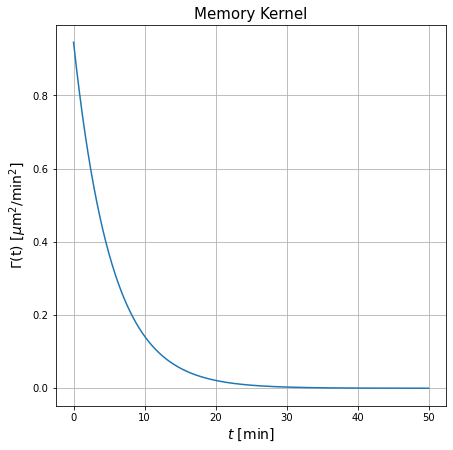

In [140]:
fig,ax = plt.subplots(figsize=(7, 7))
ax.set_ylabel('$\Gamma$(t) [$\mu$m$^2$/min$^2$]', fontsize=14)
ax.set_xlabel('$t$ [min]', fontsize=14)
ax.set_title('Memory Kernel', fontsize=15)
ax.grid()
ax.plot(np.arange(len(K[1:]))*dt, K[1:])


#plt.savefig('kernel1_fit.png')
plt.show()

**Computation of $\Delta_{msd}(t)$**

In [98]:
msd  = np.zeros_like(X)
for l in range(N+1):
    msd[l] = (X[0] - X[l])**2+(Y[0] - Y[l])**2

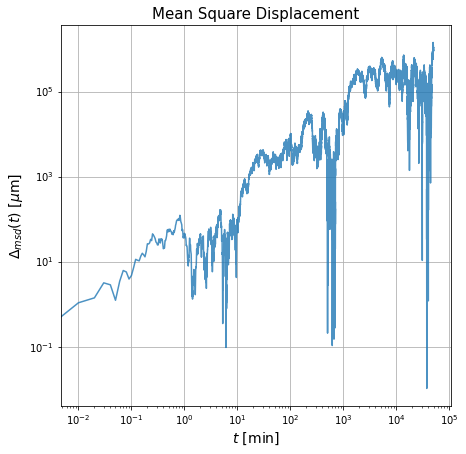

In [99]:
fig,ax = plt.subplots(figsize=(7, 7))
ax.set_ylabel('$\Delta_{msd}(t)$ [$\mu$m]', fontsize=14)
ax.set_xlabel('$t$ [min]', fontsize=14)
ax.set_title('Mean Square Displacement', fontsize=15)
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid()

ax.plot(time, msd, alpha = 0.8)
#plt.savefig('msd')
plt.show()